<a href="https://colab.research.google.com/github/juansebastiangit/Inteigencia_artificial/blob/main/Tareas/Taller_Pre_Parcial_Juan_Sebastian_Hern%C3%A1ndez_y_Carlos_Mario_Tabares_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import sklearn
import tensorflow as tf
from tensorflow import keras


# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "autoencoders"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [3]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

In [4]:
np.random.seed(4)

def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data

X_train = generate_3d_data(60)
X_train = X_train - X_train.mean(axis=0, keepdims=0)

In [5]:
np.random.seed(42)
tf.random.set_seed(42)

encoder = keras.models.Sequential([keras.layers.Dense(2, input_shape=[3])])
decoder = keras.models.Sequential([keras.layers.Dense(3, input_shape=[2])])
autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.compile(loss="mae", optimizer=keras.optimizers.SGD(learning_rate=1.5))

In [6]:
history = autoencoder.fit(X_train, X_train, epochs=20)

Epoch 1/20
2/2 [==============================] - 1s 11ms/step - loss: 0.4193
Epoch 2/20
2/2 [==============================] - 0s 7ms/step - loss: 0.4992
Epoch 3/20
2/2 [==============================] - 0s 6ms/step - loss: 0.3749
Epoch 4/20
2/2 [==============================] - 0s 7ms/step - loss: 0.2785
Epoch 5/20
2/2 [==============================] - 0s 6ms/step - loss: 0.3212
Epoch 6/20
2/2 [==============================] - 0s 7ms/step - loss: 0.2505
Epoch 7/20
2/2 [==============================] - 0s 6ms/step - loss: 0.2563
Epoch 8/20
2/2 [==============================] - 0s 6ms/step - loss: 0.2917
Epoch 9/20
2/2 [==============================] - 0s 10ms/step - loss: 0.2385
Epoch 10/20
2/2 [==============================] - 0s 5ms/step - loss: 0.3282
Epoch 11/20
2/2 [==============================] - 0s 5ms/step - loss: 0.3727
Epoch 12/20
2/2 [==============================] - 0s 6ms/step - loss: 0.2605
Epoch 13/20
2/2 [==============================] - 0s 9ms/step - loss: 

In [7]:
codings = encoder.predict(X_train)

2/2 [==============================] - 0s 4ms/step


Saving figure linear_autoencoder_pca_plot


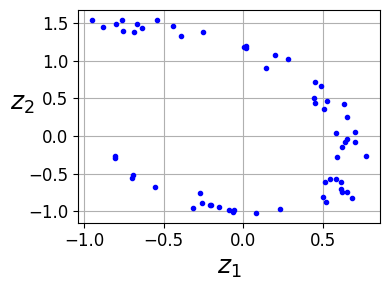

In [8]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings[:,0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
save_fig("linear_autoencoder_pca_plot")
plt.show()

In [9]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

4422102/4422102 [==============================] - 0s 0us/step


In [10]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [47]:
tf.random.set_seed(42)
np.random.seed(42)
callback=keras.callbacks.EarlyStopping(monitor='loss',patience=5,verbose=1,restore_best_weights=True,start_from_epoch=40)

stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(150, activation="elu"),
    keras.layers.Dense(150, activation="elu"),
    keras.layers.Dense(50, activation="elu"),
])
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(150, activation="elu", input_shape=[50]),
    keras.layers.Dense(28 * 28, activation="elu"),
    keras.layers.Reshape([28, 28])
])
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="mse",# cada pixel como probailidad de membresia, por eso se usa cross entropy, converge mas rapido
                   optimizer=keras.optimizers.SGD(learning_rate=1), metrics=[rounded_accuracy])
history = stacked_ae.fit(X_train, X_train,batch_size=50, epochs=100,
                         validation_data=(X_valid, X_valid),callbacks=[callback])

Epoch 1/100
1719/1719 [==============================] - 11s 6ms/step - loss: 0.1238 - rounded_accuracy: 0.8769 - val_loss: 0.1081 - val_rounded_accuracy: 0.8980
Epoch 2/100
1719/1719 [==============================] - 10s 6ms/step - loss: 0.0961 - rounded_accuracy: 0.9066 - val_loss: 0.0917 - val_rounded_accuracy: 0.9106
Epoch 3/100
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0880 - rounded_accuracy: 0.9148 - val_loss: 0.0880 - val_rounded_accuracy: 0.9167
Epoch 4/100
1719/1719 [==============================] - 10s 6ms/step - loss: 0.0831 - rounded_accuracy: 0.9206 - val_loss: 0.0791 - val_rounded_accuracy: 0.9240
Epoch 5/100
1719/1719 [==============================] - 10s 6ms/step - loss: 0.0797 - rounded_accuracy: 0.9245 - val_loss: 0.0792 - val_rounded_accuracy: 0.9236
Epoch 6/100
1719/1719 [==============================] - 10s 6ms/step - loss: 0.0771 - rounded_accuracy: 0.9276 - val_loss: 0.0749 - val_rounded_accuracy: 0.9293
Epoch 7/100
1719/1719 [======

In [48]:
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

1/1 [==============================] - 0s 130ms/step
Saving figure reconstruction_plot


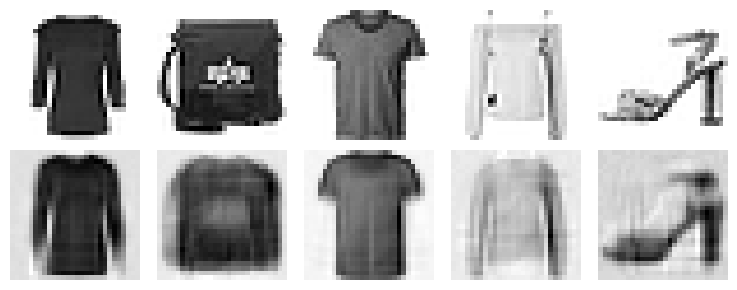

In [49]:
show_reconstructions(stacked_ae)
save_fig("reconstruction_plot")

In [42]:
np.random.seed(42)

from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min()) #normalizar rango dinamico

157/157 [==============================] - 0s 2ms/step


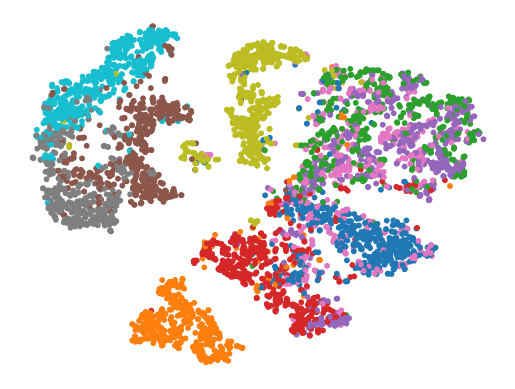

In [43]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.axis("off")
plt.show()

Saving figure fashion_mnist_visualization_plot


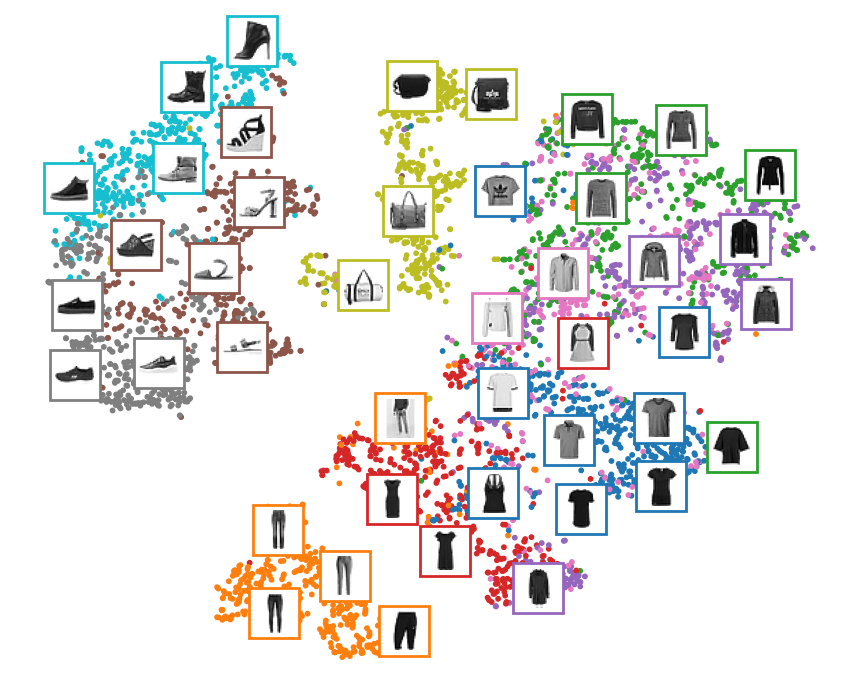

In [44]:
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.01: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
save_fig("fashion_mnist_visualization_plot")
plt.show()

In [ ]:
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)
    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias",
                                      shape=[self.dense.input_shape[-1]],
                                      initializer="zeros",kernel_regularizer=keras.regularizers.l2(0.01))
        super().build(batch_input_shape)
    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
callback=keras.callbacks.EarlyStopping(monitor='val_loss',patience=2)

dense_1 = keras.layers.Dense(500, activation="selu",kernel_regularizer=keras.regularizers.l2(0.02))
dense_2 = keras.layers.Dense(200, activation="selu",kernel_regularizer=keras.regularizers.l2(0.02))
dense_3 = keras.layers.Dense(100, activation="selu",kernel_regularizer=keras.regularizers.l2(0.02))

tied_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    dense_1,
    keras.layers.BatchNormalization(),
    dense_2,
    keras.layers.BatchNormalization(),
    dense_3,
    keras.layers.BatchNormalization(),
])

tied_decoder = keras.models.Sequential([
    DenseTranspose(dense_3, activation="selu"),
    keras.layers.BatchNormalization(),
    DenseTranspose(dense_2, activation="selu"),
    keras.layers.BatchNormalization(),
    DenseTranspose(dense_1, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

tied_ae = keras.models.Sequential([tied_encoder, tied_decoder])

tied_ae.compile(loss="mse",
                optimizer=keras.optimizers.SGD(lr=1), metrics=[rounded_accuracy])
history = tied_ae.fit(X_train, X_train,64, epochs=50,
                      validation_data=(X_valid, X_valid))

Epoch 1/50
860/860 [==============================] - 10s 8ms/step - loss: 15.0393 - rounded_accuracy: 0.5859 - val_loss: 10.4837 - val_rounded_accuracy: 0.6152
Epoch 2/50
860/860 [==============================] - 7s 9ms/step - loss: 7.6215 - rounded_accuracy: 0.6438 - val_loss: 5.3357 - val_rounded_accuracy: 0.6763
Epoch 3/50
860/860 [==============================] - 8s 9ms/step - loss: 3.8991 - rounded_accuracy: 0.6948 - val_loss: 2.7539 - val_rounded_accuracy: 0.7119
Epoch 4/50
860/860 [==============================] - 7s 8ms/step - loss: 2.0322 - rounded_accuracy: 0.7186 - val_loss: 1.4588 - val_rounded_accuracy: 0.7271
Epoch 5/50
860/860 [==============================] - 8s 9ms/step - loss: 1.0955 - rounded_accuracy: 0.7291 - val_loss: 0.8086 - val_rounded_accuracy: 0.7357
Epoch 6/50
860/860 [==============================] - 9s 10ms/step - loss: 0.6253 - rounded_accuracy: 0.7366 - val_loss: 0.4822 - val_rounded_accuracy: 0.7442
Epoch 7/50
860/860 [============================

1/1 [==============================] - 0s 170ms/step


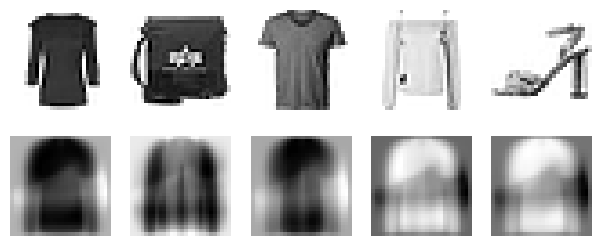

In [ ]:
show_reconstructions(tied_ae)
plt.show()

In [ ]:
np.random.seed(42)

from sklearn.manifold import TSNE

X_valid_compressed = tied_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min()) #normalizar rango dinamico

157/157 [==============================] - 0s 2ms/step


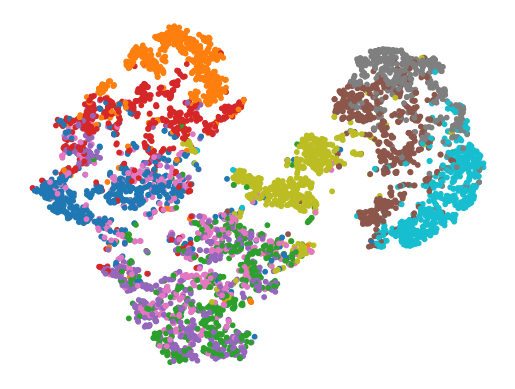

In [ ]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.axis("off")
plt.show()

Saving figure fashion_mnist_visualization_plot


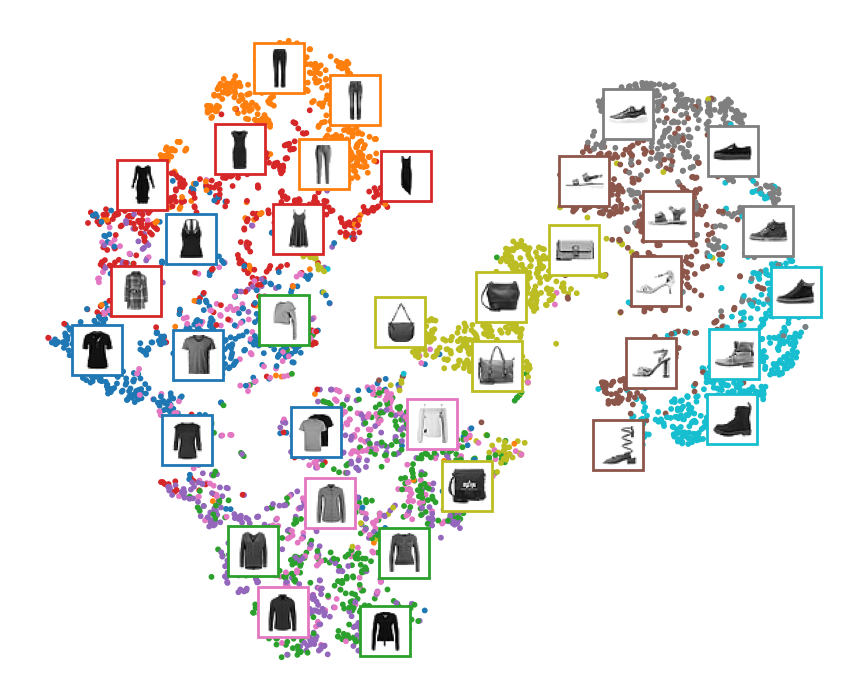

In [ ]:
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.01: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
save_fig("fashion_mnist_visualization_plot")
plt.show()